On this notebook, I will try to implement AutoEncoders on another image dataset but on a more sophisticated problem. 
On the previous notebook we gave a brief introduction on how do AutoEncoders work but this time I will detail the info with a copy pasted text from François Chollet from the keras documentation webpage:

![title](images/auto_enc1.png)

## Introduction

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.


In [118]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [156]:
!nvidia-smi | grep "Tesla"

|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |


In [120]:
train_ds = tfds.load('coil100', split='train', batch_size=-1)
train_ds.keys()

dict_keys(['image', 'label', 'object_id'])

In [121]:
x_train, x_test = np.array([img for img in train_ds['image'][:6000]]), np.array([img for img in train_ds['image'][6000:]])
del train_ds

In [122]:
sizes = [img.shape for img in x_train]
# sizes

In [123]:
encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
encoder_output = keras.layers.Dense(64, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(16384, activation="relu")(decoder_input)
decoder_output = keras.layers.Reshape((128, 128, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=5, batch_size=32, validation_split=0.10)   

Epoch 1/5
169/169 [==============================] - 1s 6ms/step - loss: 4847.1754 - val_loss: 2213.9253
Epoch 2/5
169/169 [==============================] - 1s 5ms/step - loss: 2151.6418 - val_loss: 2072.1948
Epoch 3/5
169/169 [==============================] - 1s 5ms/step - loss: 2053.7927 - val_loss: 2011.2300
Epoch 4/5
169/169 [==============================] - 1s 5ms/step - loss: 1989.1394 - val_loss: 1981.1848
Epoch 5/5
169/169 [==============================] - 1s 5ms/step - loss: 1970.0567 - val_loss: 1924.5917


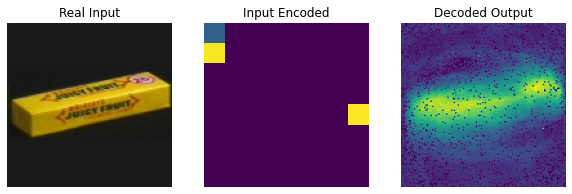

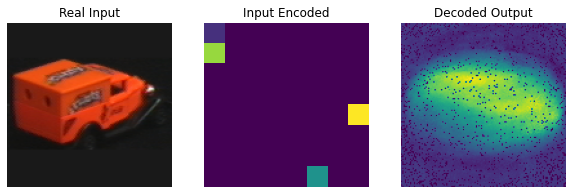

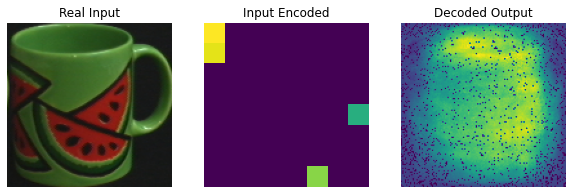

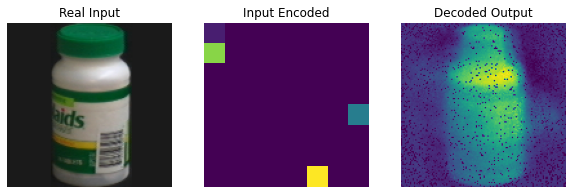

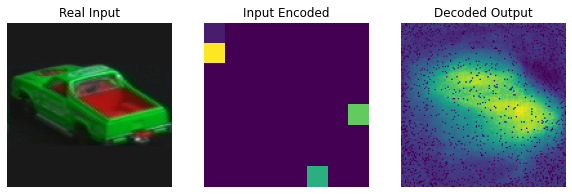

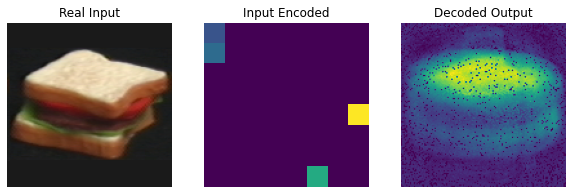

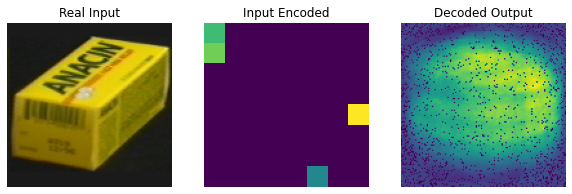

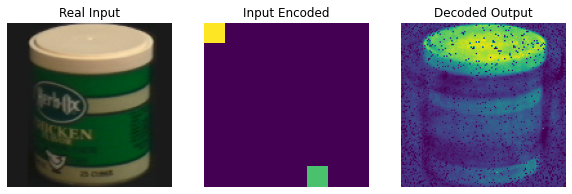

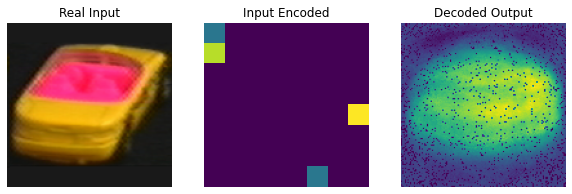

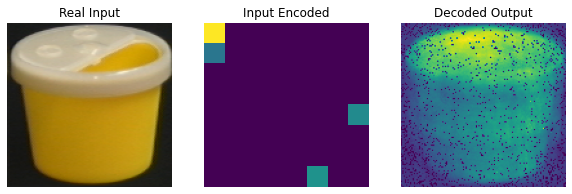

In [124]:
def show_results(img, dims):
    fig, axes = plt.subplots(ncols=3, figsize=(dims, dims))
    ax1, ax2, ax3 = axes
    ax1.axis('off')
    ax1.set_title('Real Input')
    ax2.axis('off')
    ax2.set_title('Input Encoded')
    ax3.axis('off')
    ax3.set_title('Decoded Output')
    ax1.imshow(img)
    ax2.imshow(encoder.predict(img.reshape(-1, 128, 128, 3)).reshape((8, 8)))
    ax3.imshow(autoencoder.predict(img.reshape(-1, 128, 128, 3)).reshape((128, 128)))
    plt.show()

for i in range(30, 40):
  show_results(x_test[i], 10)

We are observing terrible results encoding and decoding. The values for loss during training were huge. Let us train for more epochs and a more complicated model.

In [125]:
# Create the custom callback

class reduce_prints(tf.keras.callbacks.Callback):
    # Print the loss and mean absolute error after each epoch
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 ==0:
            print('Epoch {}: Average loss is {:7.2f}, mean absolute error is {:7.2f}.'.format(epoch, logs['loss'], logs['val_loss']))


In [126]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=500, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints()])   

Epoch 0: Average loss is 1885.29, mean absolute error is 1888.47.
Epoch 100: Average loss is 1440.23, mean absolute error is 1488.74.
Epoch 200: Average loss is 1422.20, mean absolute error is 1504.23.
Epoch 300: Average loss is 1407.79, mean absolute error is 1515.47.
Epoch 400: Average loss is 1378.31, mean absolute error is 1476.98.


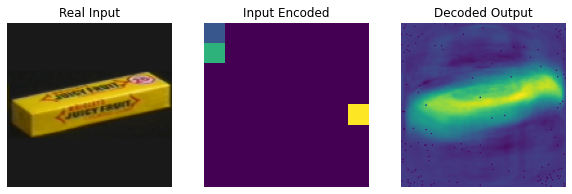

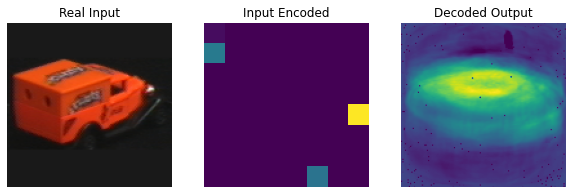

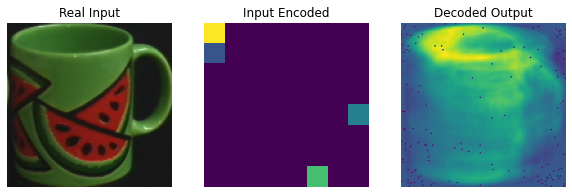

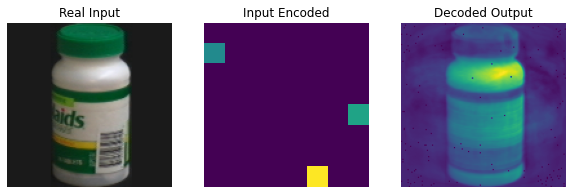

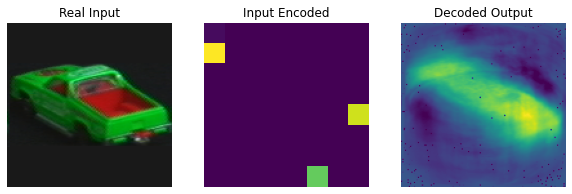

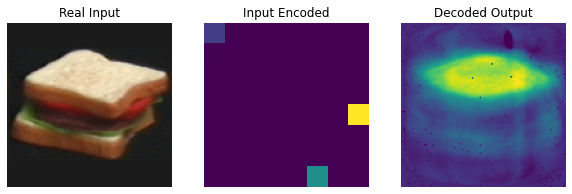

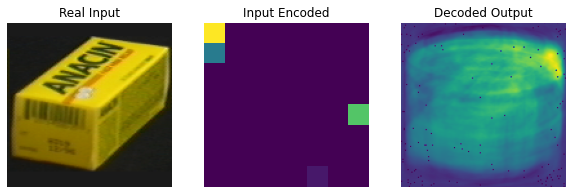

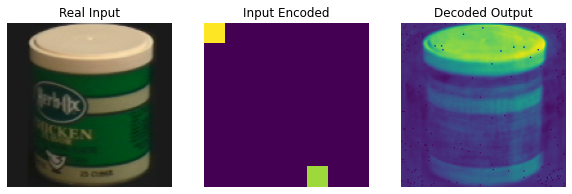

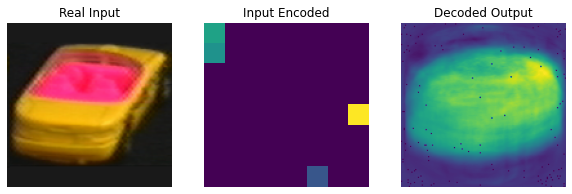

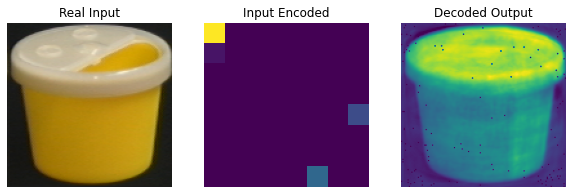

In [127]:
for i in range(30, 40):
  show_results(x_test[i], 10)

We keep obtaining terrible results. Let us plot the history and try to improve the model

dict_keys(['loss', 'val_loss'])


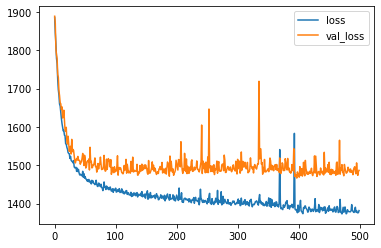

In [128]:
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

We see we are not overfitting but metrics are becoming saturated so we do not need to include regularization methods.

---



In [129]:
encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x)
encoder_output = keras.layers.Dense(64, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu")(decoder_input)
x = keras.layers.Dense(16384, activation="relu")(x)
decoder_output = keras.layers.Reshape((128, 128, 1))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=500, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints()])   

Epoch 0: Average loss is 2692.79, mean absolute error is 1916.12.
Epoch 100: Average loss is 1107.74, mean absolute error is 1131.32.
Epoch 200: Average loss is 1094.63, mean absolute error is 1132.91.
Epoch 300: Average loss is 1083.59, mean absolute error is 1132.74.
Epoch 400: Average loss is 1076.41, mean absolute error is 1123.13.


Text(0.5, 1.0, "['Second Autoencoder']")

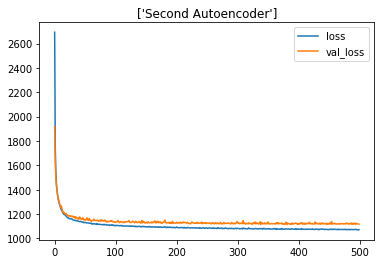

In [130]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Second Autoencoder'])

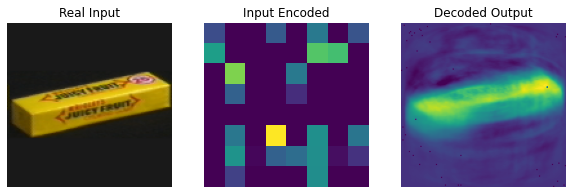

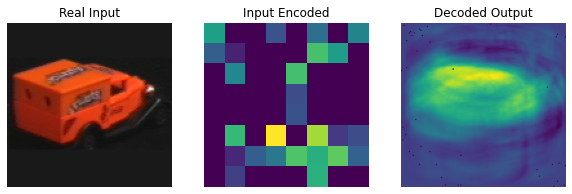

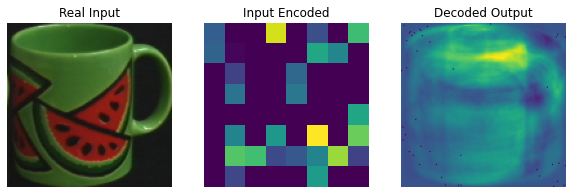

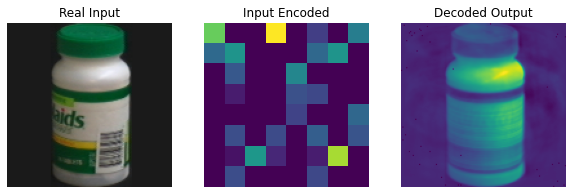

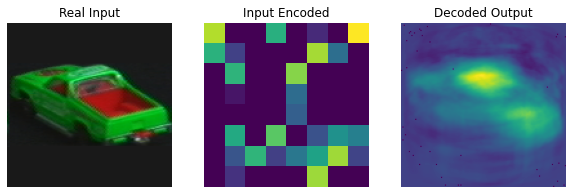

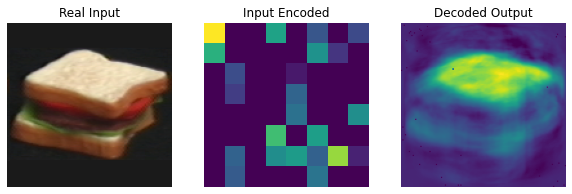

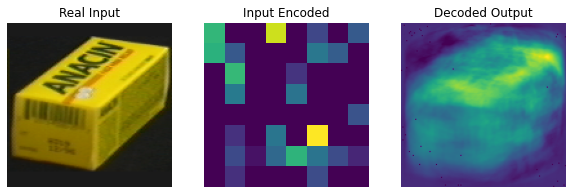

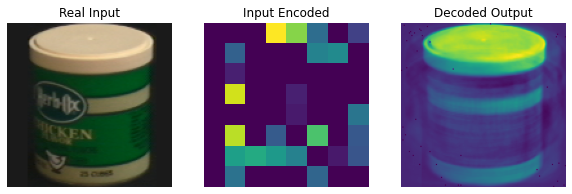

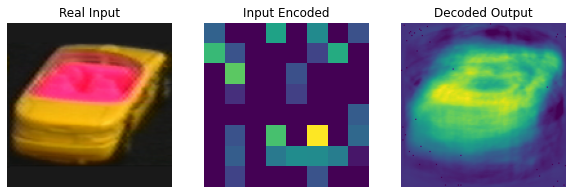

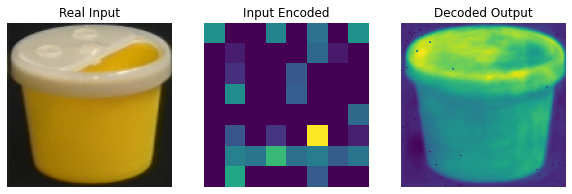

In [131]:
for i in range(30, 40):
  show_results(x_test[i], 10)

But wait, why are we obtaining flat images if we are using full color images??
This is because the reshape layer, it is flattening the outputs. Let us change that.  We need also to include 128 times 128 times 3 neurons on the layer before the reshape Layer.

In [132]:
encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(32, activation="relu")(x)
encoder_output = keras.layers.Dense(64, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu")(decoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(49152, activation="relu")(x)
decoder_output = keras.layers.Reshape((128, 128, 3))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=500, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints()])   

Epoch 0: Average loss is 2038.31, mean absolute error is 1180.87.
Epoch 100: Average loss is  388.89, mean absolute error is  479.55.
Epoch 200: Average loss is  362.86, mean absolute error is  456.74.
Epoch 300: Average loss is  355.64, mean absolute error is  458.03.
Epoch 400: Average loss is  353.25, mean absolute error is  456.78.


Text(0.5, 1.0, "['Second Autoencoder with 3D']")

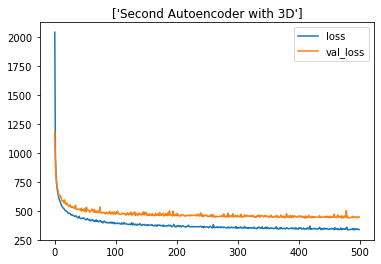

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Second Autoencoder with 3D'])

In [134]:
def show_results(img, dims):
    fig, axes = plt.subplots(ncols=3, figsize=(dims, dims))
    ax1, ax2, ax3 = axes
    ax1.axis('off')
    ax1.set_title('Real Input')
    ax2.axis('off')
    ax2.set_title('Input Encoded')
    ax3.axis('off')
    ax3.set_title('Decoded Output')
    ax1.imshow(img)
    ax2.imshow(encoder.predict(img.reshape(-1, 128, 128, 3)).reshape((8, 8)))
    ax3.imshow(autoencoder.predict(img.reshape(-1, 128, 128, 3)).reshape((128, 128, 3)).astype('uint8'))
    plt.show()

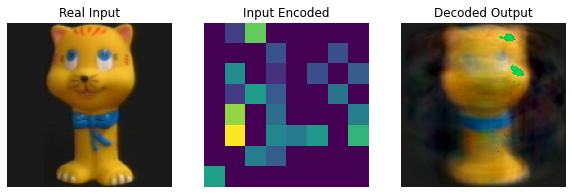

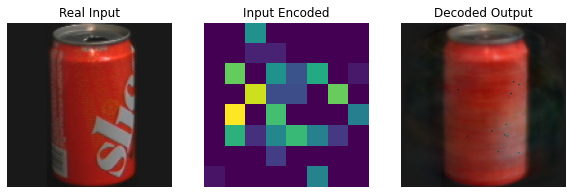

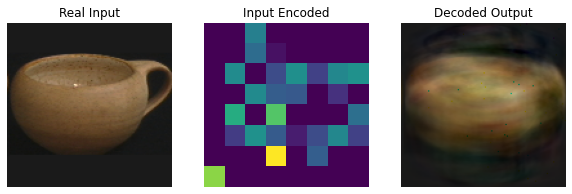

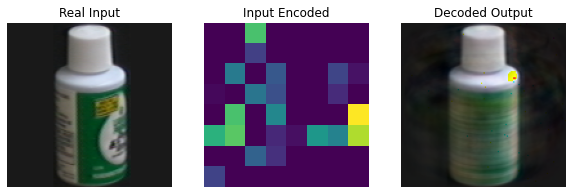

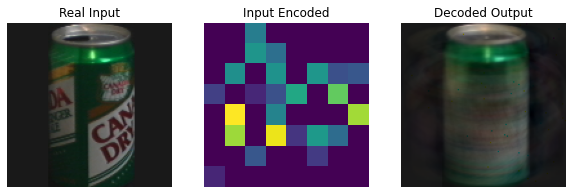

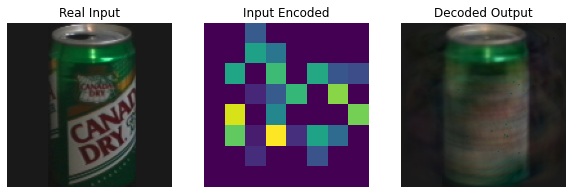

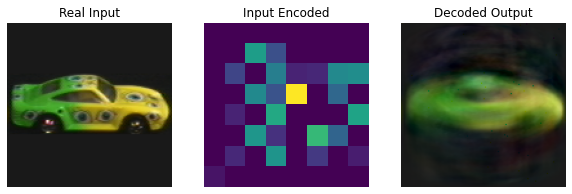

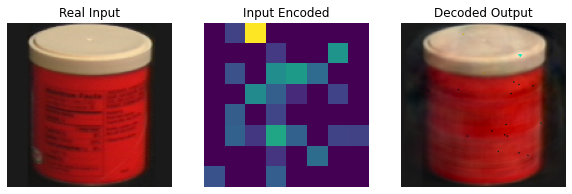

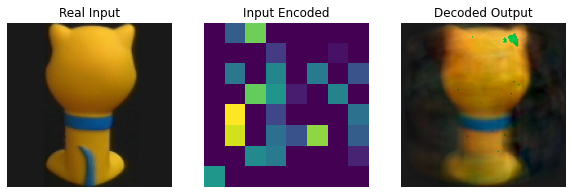

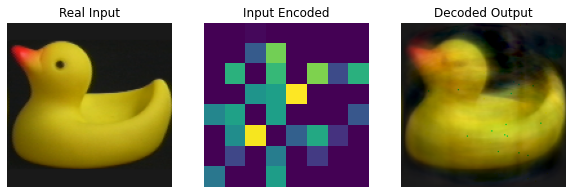

In [135]:
for i in range(80, 90):
  show_results(x_test[i], 10)

Thanks to not flatten the images the loss is decreasing even faster. There is a curious effect of movement on the pictures, haha, but we see we are able to distinguish the pictures pretty well with a factor compression of $64/(128*128*3)$. We could aim for a more complex model in order to decrease the loss and obtain a better model. Again, as we are not observing significant effects of overfitting I will not use regularization techniques. 

In [136]:
encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
encoder_output = keras.layers.Dense(256, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu")(decoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(49152, activation="relu")(x)
decoder_output = keras.layers.Reshape((128, 128, 3))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=500, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints(), tf.keras.callbacks.ReduceLROnPlateau(
        patience = 50, monitor="val_loss",factor=0.2, verbose=1)])   

Epoch 0: Average loss is 1958.32, mean absolute error is 1276.65.
Epoch 100: Average loss is  305.83, mean absolute error is  396.47.
Epoch 200: Average loss is  283.37, mean absolute error is  387.30.
Epoch 300: Average loss is  259.85, mean absolute error is  366.22.

Epoch 00310: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00370: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 400: Average loss is  205.75, mean absolute error is  340.55.

Epoch 00424: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00474: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


Text(0.5, 1.0, "['Third Autoencoder with 3D']")

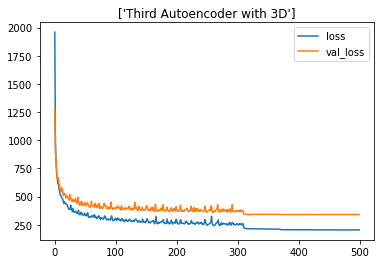

In [137]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Third Autoencoder with 3D'])

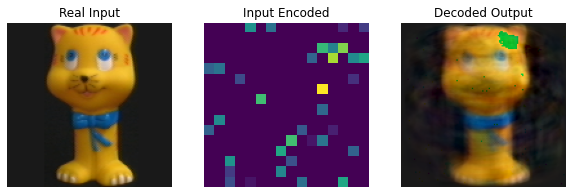

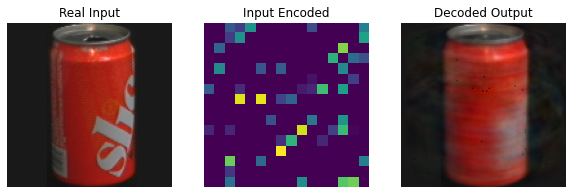

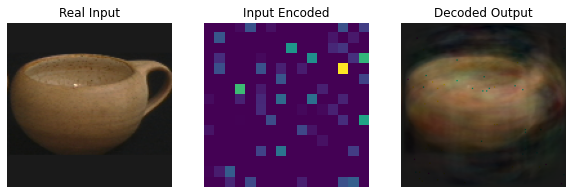

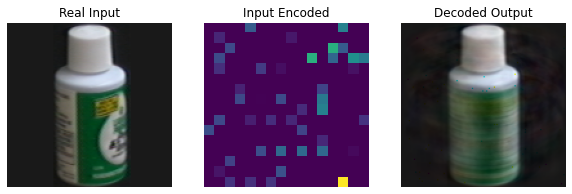

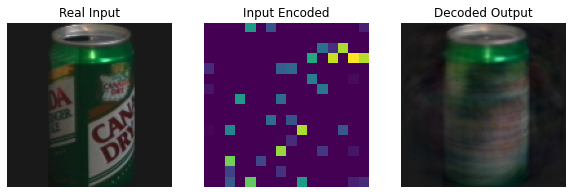

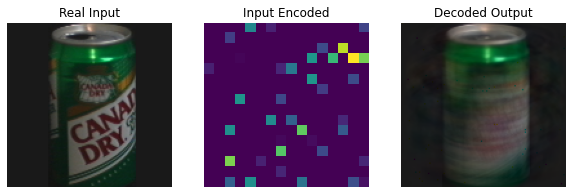

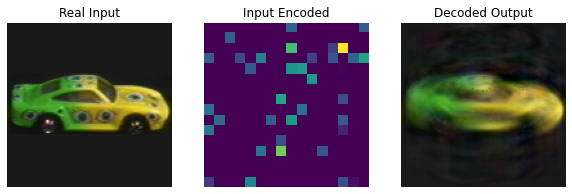

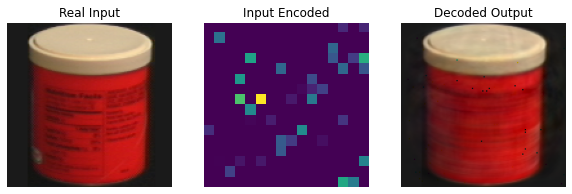

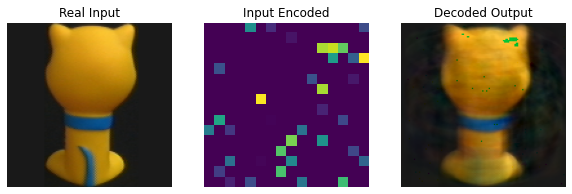

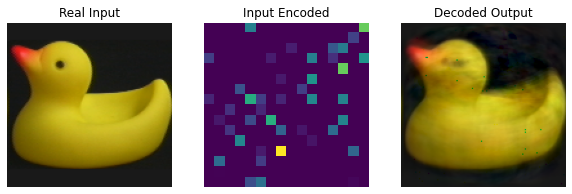

In [140]:
def show_results(img, dims):
    fig, axes = plt.subplots(ncols=3, figsize=(dims, dims))
    ax1, ax2, ax3 = axes
    ax1.axis('off')
    ax1.set_title('Real Input')
    ax2.axis('off')
    ax2.set_title('Input Encoded')
    ax3.axis('off')
    ax3.set_title('Decoded Output')
    ax1.imshow(img)
    ax2.imshow(encoder.predict(img.reshape(-1, 128, 128, 3)).reshape((16, 16)))
    ax3.imshow(autoencoder.predict(img.reshape(-1, 128, 128, 3)).reshape((128, 128, 3)).astype('uint8'))
    plt.show()


for i in range(80, 90):
  show_results(x_test[i], 10)

Although we have reduced a lot the loss, we still have some problems to understand the outputs. The factor compression is still huge. I might be wrong with the idea of not being overfitting just because both train and val loss decrease a lot from the entry point. Let us make one last experiment to try to reduce a bit the overfitting and see if the results improve.

In [145]:
from keras.layers import Dropout

encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
encoder_output = keras.layers.Dense(256, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(decoder_input)
x = keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = keras.layers.Dense(49152, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
decoder_output = keras.layers.Reshape((128, 128, 3))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=800, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints(), tf.keras.callbacks.ReduceLROnPlateau(
        patience = 30, monitor="val_loss",factor=0.2, verbose=1)])   

Epoch 0: Average loss is 2584.88, mean absolute error is 2514.28.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 100: Average loss is 1016.44, mean absolute error is 2177.54.

Epoch 00110: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00140: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
Epoch 200: Average loss is 1006.90, mean absolute error is 2187.91.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 2.5600002118153498e-09.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 5.1200004236307e-10.
Epoch 300: Average loss is 1004.36, mean absolute error is 2188.14

Text(0.5, 1.0, "['Last Autoencoder with 3D']")

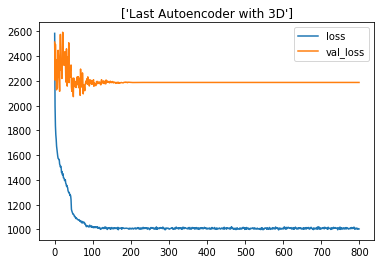

In [146]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Last Autoencoder with 3D'])

In [157]:
# for i in range(80, 90):
#   show_results(x_test[i], 10)

In [150]:
from keras.layers import Dropout

encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(128, activation="relu")(x)
x = Dropout(0.15)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = Dropout(0.35)(x)
encoder_output = keras.layers.Dense(256, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu")(decoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = Dropout(0.15)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = Dropout(0.35)(x)
x = keras.layers.Dense(49152, activation="relu")(x)
decoder_output = keras.layers.Reshape((128, 128, 3))(x)

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

history = autoencoder.fit(
    x_train, x_train,
    epochs=800, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints(), tf.keras.callbacks.ReduceLROnPlateau(
        patience = 50, monitor="val_loss",factor=0.2, verbose=1)])  

Epoch 0: Average loss is 2538.57, mean absolute error is 2583.56.
Epoch 100: Average loss is 1064.30, mean absolute error is 1602.63.
Epoch 200: Average loss is 1000.42, mean absolute error is 1438.80.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 300: Average loss is  844.70, mean absolute error is 1282.68.

Epoch 00326: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 00376: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 400: Average loss is  818.39, mean absolute error is 1300.64.

Epoch 00426: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.

Epoch 00476: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
Epoch 500: Average loss is  812.01, mean absolute error is 1297.11.

Epoch 00526: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.

Epoch 00576: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
Epoch 600: Average loss

Text(0.5, 1.0, "['Last Autoencoder with 3D']")

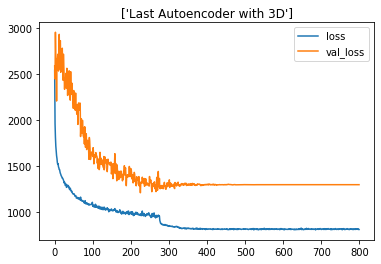

In [151]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Last Autoencoder with 3D'])

Once again, we can clearly see the model is worsening. The initial hypothsis about not incurring into overfitting was totaly true. So, we can train a more complex model. If this does not get better, we can be sure that the key is in the final space to encode data. Let us insert 2 more layers on the encoder and on the decoder.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 49152)             0         
_________________________________________________________________
dense_105 (Dense)            (None, 256)               12583168  
_________________________________________________________________
dense_106 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_107 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_108 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_109 (Dense)            (None, 64)                

Text(0.5, 1.0, "['Most Complex Autoencoder']")

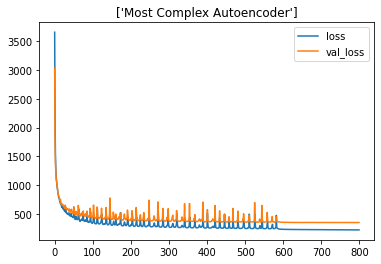

In [154]:
from keras.layers import Dropout

encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
encoder_output = keras.layers.Dense(256, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu")(decoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(49152, activation="relu")(x)
decoder_output = keras.layers.Reshape((128, 128, 3))(x)



opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

print(autoencoder.summary())

history = autoencoder.fit(
    x_train, x_train,
    epochs=800, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints(), tf.keras.callbacks.ReduceLROnPlateau(
        patience = 50, monitor="val_loss",factor=0.2, verbose=1)]) 



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Most Complex Autoencoder'])

We see that the model has not improved from the original version. So, the key must be on the space to encode input data. As a final experiment, let us run a model similar to the last one but with a higher dimensional space to encode data. We will do this experiment without the ReduceLRonPlateau callback and just changing the lr by the adam optimizer.

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 128, 128, 3)]     0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 49152)             0         
_________________________________________________________________
dense_133 (Dense)            (None, 256)               12583168  
_________________________________________________________________
dense_134 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_135 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_136 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_137 (Dense)            (None, 64)                

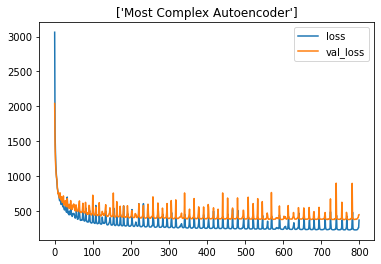

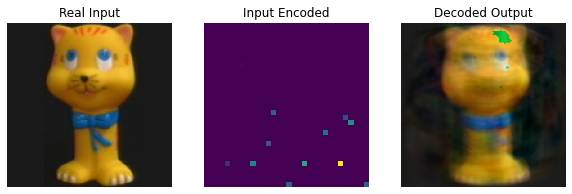

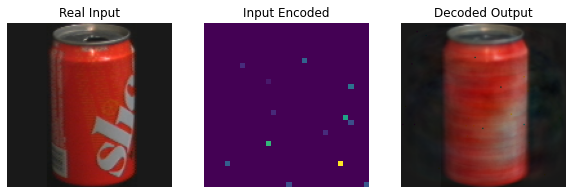

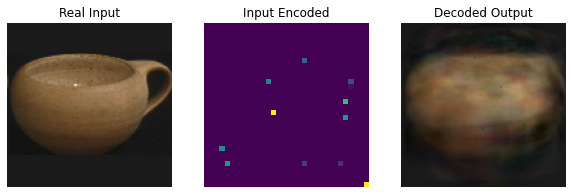

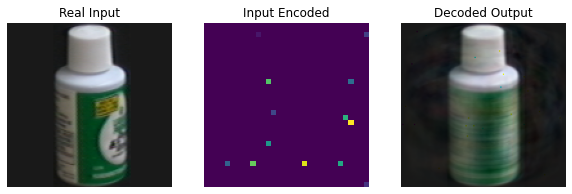

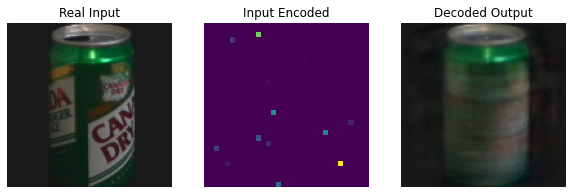

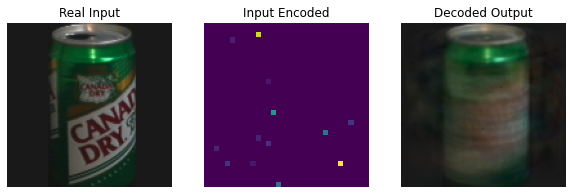

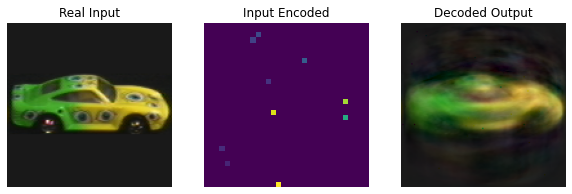

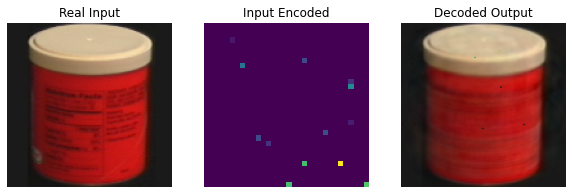

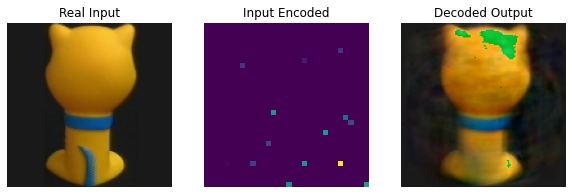

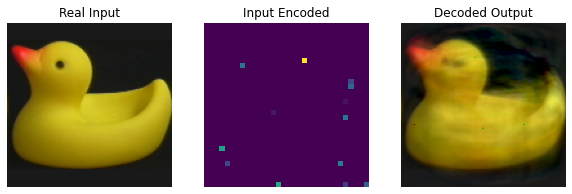

In [159]:
from keras.layers import Dropout

encoder_input = keras.Input(shape=(128, 128, 3), name='img')
x = keras.layers.Flatten()(encoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dense(128, activation="relu")(x)
encoder_output = keras.layers.Dense(1024, activation="relu")(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.Dense(64, activation="relu")(encoder_output)
x = keras.layers.Dense(128, activation="relu")(decoder_input)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(49152, activation="relu")(x)
decoder_output = keras.layers.Reshape((128, 128, 3))(x)



opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.compile(opt, loss='mse')

print(autoencoder.summary())

history = autoencoder.fit(
    x_train, x_train,
    epochs=800, batch_size=32, validation_split=0.10, verbose = False, callbacks=[reduce_prints()]) 



plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title(['Most Complex Autoencoder'])



def show_results(img, dims):
    fig, axes = plt.subplots(ncols=3, figsize=(dims, dims))
    ax1, ax2, ax3 = axes
    ax1.axis('off')
    ax1.set_title('Real Input')
    ax2.axis('off')
    ax2.set_title('Input Encoded')
    ax3.axis('off')
    ax3.set_title('Decoded Output')
    ax1.imshow(img)
    ax2.imshow(encoder.predict(img.reshape(-1, 128, 128, 3)).reshape((32, 32)))
    ax3.imshow(autoencoder.predict(img.reshape(-1, 128, 128, 3)).reshape((128, 128, 3)).astype('uint8'))
    plt.show()


for i in range(80, 90):
  show_results(x_test[i], 10)